In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pandas_profiling
import statsmodels.api as sm

import matplotlib.pylab as plt
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

## Loading Data

In [2]:
json_path = '/Users/stuti/Documents/consumer trends/Dashmote_data_set_case.json'
df = pd.read_json(json_path, lines=True)
df.head()

,cluster,id,user_id,url,date_month,hashtags,date_unix,comments,date_week,likes,date_formated
0,buzzcut,BOuvqVnA8or,2963637811,https://scontent-vie1-1.cdninstagram.com/t51.2...,1,"[#shooting, #photography, #studiophotography, ...",1483292238,19,52,269,01-01-2017
1,chignon,BOuxiZXBee-,2897380111,https://scontent-vie1-1.cdninstagram.com/t51.2...,1,"[#chignon, #insta, #instapic, #liveyourlife, #...",1483293222,38,52,222,01-01-2017
2,wetlook,BOvI621jm4n,190130788,https://scontent-vie1-1.cdninstagram.com/t51.2...,1,"[#happynewyear, #magic, #christmas, #look, #ch...",1483305481,15,52,182,01-01-2017
3,hairflip,BOvSR4OgxAq,181138901,https://scontent-vie1-1.cdninstagram.com/t51.2...,1,"[#2017whatsgood, #nyc, #nye, #toshi, #firstNYE...",1483310388,18,52,112,01-01-2017
4,halfupdo,BOuzqkSAO_7,1963048049,https://scontent-vie1-1.cdninstagram.com/t51.2...,1,"[#braidphoto, #velvetdress, #braidideas, #hair...",1483294337,28,52,174,01-01-2017


## Data exploration

In [3]:
display(df.describe())
display(df.info())

,user_id,date_month,date_unix,comments,date_week,likes
count,1.000000e+04,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,1.692523e+09,1.95330,1.485768e+09,3.108700,18.312900,56.343700
std,1.481797e+09,0.69323,1.774091e+06,23.615441,20.273581,68.537291
min,1.174800e+04,1.00000,1.483225e+09,0.000000,5.000000,0.000000
25%,2.808167e+08,1.00000,1.483308e+09,0.000000,5.000000,19.750000
50%,1.463377e+09,2.00000,1.485952e+09,1.000000,5.000000,37.000000
75%,3.009536e+09,2.00000,1.485986e+09,3.000000,52.000000,68.000000
max,4.742553e+09,3.00000,1.488409e+09,2311.000000,52.000000,2808.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cluster        10000 non-null  object
 1   id             10000 non-null  object
 2   user_id        10000 non-null  int64 
 3   url            10000 non-null  object
 4   date_month     10000 non-null  int64 
 5   hashtags       10000 non-null  object
 6   date_unix      10000 non-null  int64 
 7   comments       10000 non-null  int64 
 8   date_week      10000 non-null  int64 
 9   likes          10000 non-null  int64 
 10  date_formated  10000 non-null  object
dtypes: int64(6), object(5)
memory usage: 859.5+ KB


None

## Feature Engineering

In [4]:
# convert time to parts of day
def convert_to_day_parts(ts):
    if (0 == ts.hour and ts.minute == 0):
        return 'midnight'
    elif (0 <= ts.hour and ts.hour <= 5):
        return 'early_morning'
    elif (6 == ts.hour and ts.minute == 0):
        return 'dawn'
    elif (6 <= ts.hour and ts.hour <= 11):
        return 'morning'
    elif (12 == ts.hour and ts.minute == 0):
        return 'midday'
    elif (12 <= ts.hour and ts.hour <= 17):
        return 'afternoon'
    elif (18 == ts.hour and ts.minute == 0):
        return 'dusk'
    elif (18 <= ts.hour and ts.hour <= 23):
        return 'evening'

# extract features for more details of the dataset
# for e.g. breaking down the variable "post_date" to day of the week, month, day, year and part of the day
df['post_date'] = pd.to_datetime(df['date_unix'],unit='s')
df['dow'] = df['post_date'].apply(lambda t : t.isoweekday())
df['day'] = df['post_date'].apply(lambda t : t.day)
df['month'] = df['post_date'].apply(lambda t : t.month)
df['year'] = df['post_date'].apply(lambda t : t.year)
df['daypart'] = df['post_date'].apply(convert_to_day_parts)
df['n_tags'] = df['hashtags'].apply(len)

# dropping unnecessary variables
df.drop(['date_month', 'id', 'url', 'date_unix'], 1, inplace=True, errors='ignore')

df.head()

/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,cluster,user_id,hashtags,comments,date_week,likes,date_formated,post_date,dow,day,month,year,daypart,n_tags
0,buzzcut,2963637811,"[#shooting, #photography, #studiophotography, ...",19,52,269,01-01-2017,2017-01-01 17:37:18,7,1,1,2017,afternoon,29
1,chignon,2897380111,"[#chignon, #insta, #instapic, #liveyourlife, #...",38,52,222,01-01-2017,2017-01-01 17:53:42,7,1,1,2017,afternoon,23
2,wetlook,190130788,"[#happynewyear, #magic, #christmas, #look, #ch...",15,52,182,01-01-2017,2017-01-01 21:18:01,7,1,1,2017,evening,27
3,hairflip,181138901,"[#2017whatsgood, #nyc, #nye, #toshi, #firstNYE...",18,52,112,01-01-2017,2017-01-01 22:39:48,7,1,1,2017,evening,10
4,halfupdo,1963048049,"[#braidphoto, #velvetdress, #braidideas, #hair...",28,52,174,01-01-2017,2017-01-01 18:12:17,7,1,1,2017,evening,28


## Distribution of Continuous variables ('n_tags','likes', 'comments')

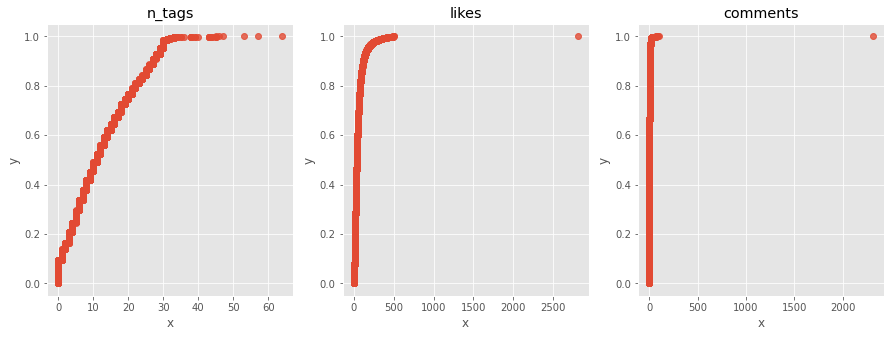

In [5]:
features = ['n_tags','likes', 'comments']
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
for i, f in enumerate(features):
    ecdf = sm.distributions.ECDF(df[f])
    ecdf = pd.DataFrame({'x' : ecdf.x,'y' : ecdf.y})
    ecdf.replace(float('-inf'), 0, inplace=True)
    g = sns.regplot(x='x', y='y', fit_reg=False, scatter=True, data=ecdf, ax=axes[i])
    g.set_title(f)

## Daily Distribution of Continuous Variables ('n_tags','likes', 'comments')

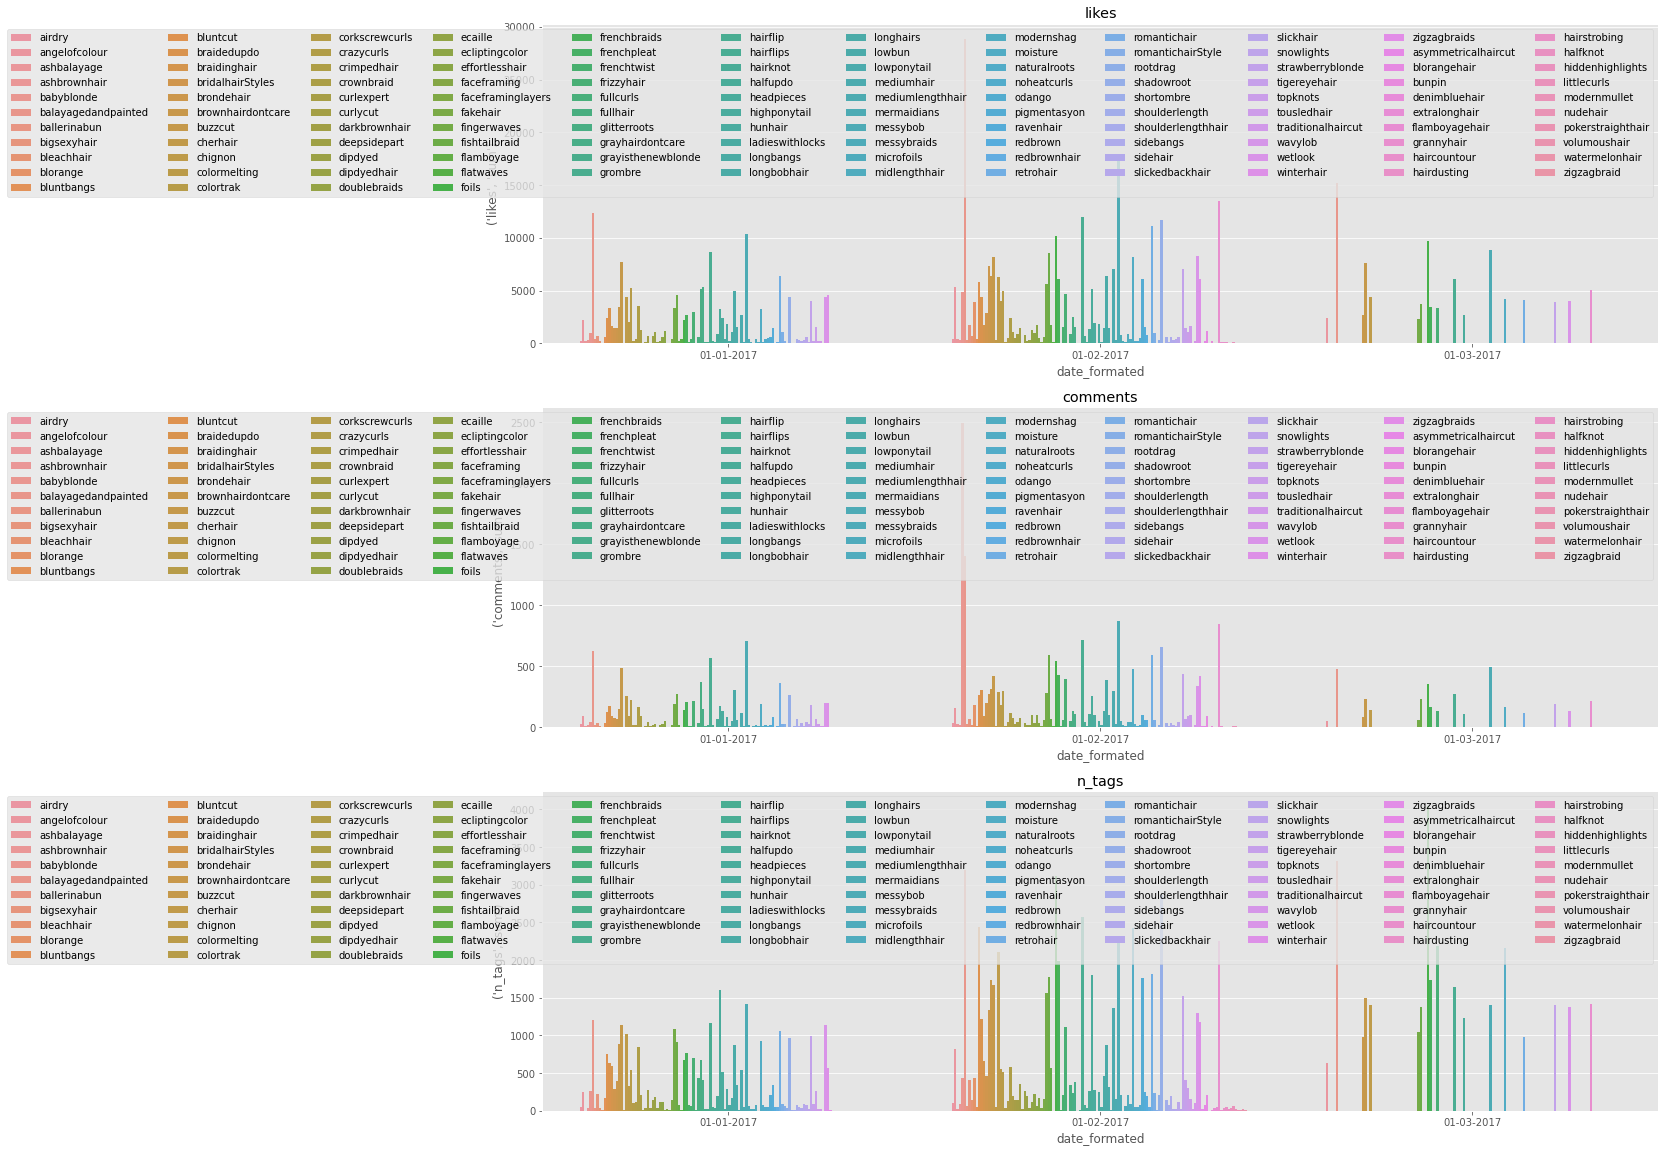

In [6]:
features = ['likes', 'comments', 'n_tags']

agg_f = {f :[sum] for f in features}
df_temp = df.groupby(['date_formated', 'cluster']).aggregate(agg_f).reset_index()

fig, axes = plt.subplots(len(features), 1, figsize=(20, 20))
for i, f in enumerate(features):
    ax = sns.barplot(x='date_formated', y=(f, 'sum'), hue='cluster', data=df_temp, ax=axes[i])
    ax.set_title(f)
    ax.legend(ncol=12)

## Bar plot for frequency of "cluster"

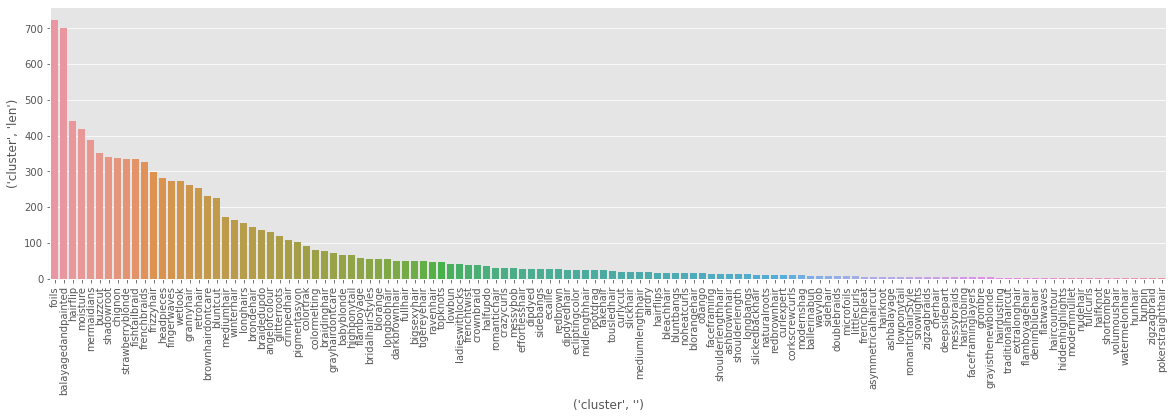

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
df_tmp = df[['cluster']].groupby(['cluster']).aggregate({'cluster' : [len]}).sort_values(('cluster', 'len'), ascending=False).reset_index()
g = sns.barplot(x=('cluster',''), y=('cluster', 'len'), data=df_tmp)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Box plots for Continuous Variables

#### 1. Box plots for likes, comments and n_tags v/s part of day

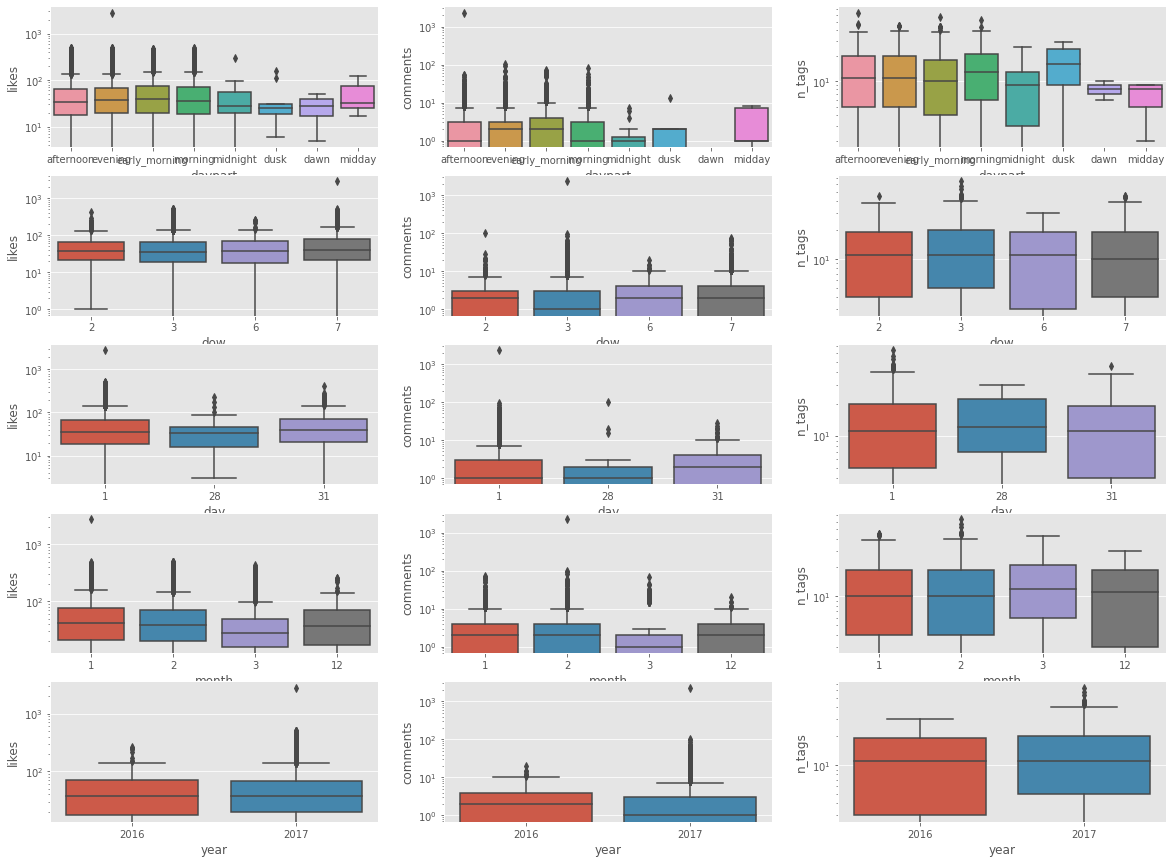

In [8]:
features = ['daypart','dow', 'day', 'month', 'year']
fig, axes = plt.subplots(len(features), 3, figsize=(20, 15))
for i, f in enumerate(features):
    g = sns.boxplot(x=f, y='likes', data=df, ax=axes[i][0])
    g.set_yscale('log')
    
    g = sns.boxplot(x=f, y='comments', data=df, ax=axes[i][1])
    g.set_yscale('log')
    
    g = sns.boxplot(x=f, y='n_tags', data=df, ax=axes[i][2])
    g.set_yscale('log')

#### 2. Box plots for likes, comments and n_tags v/s cluster type

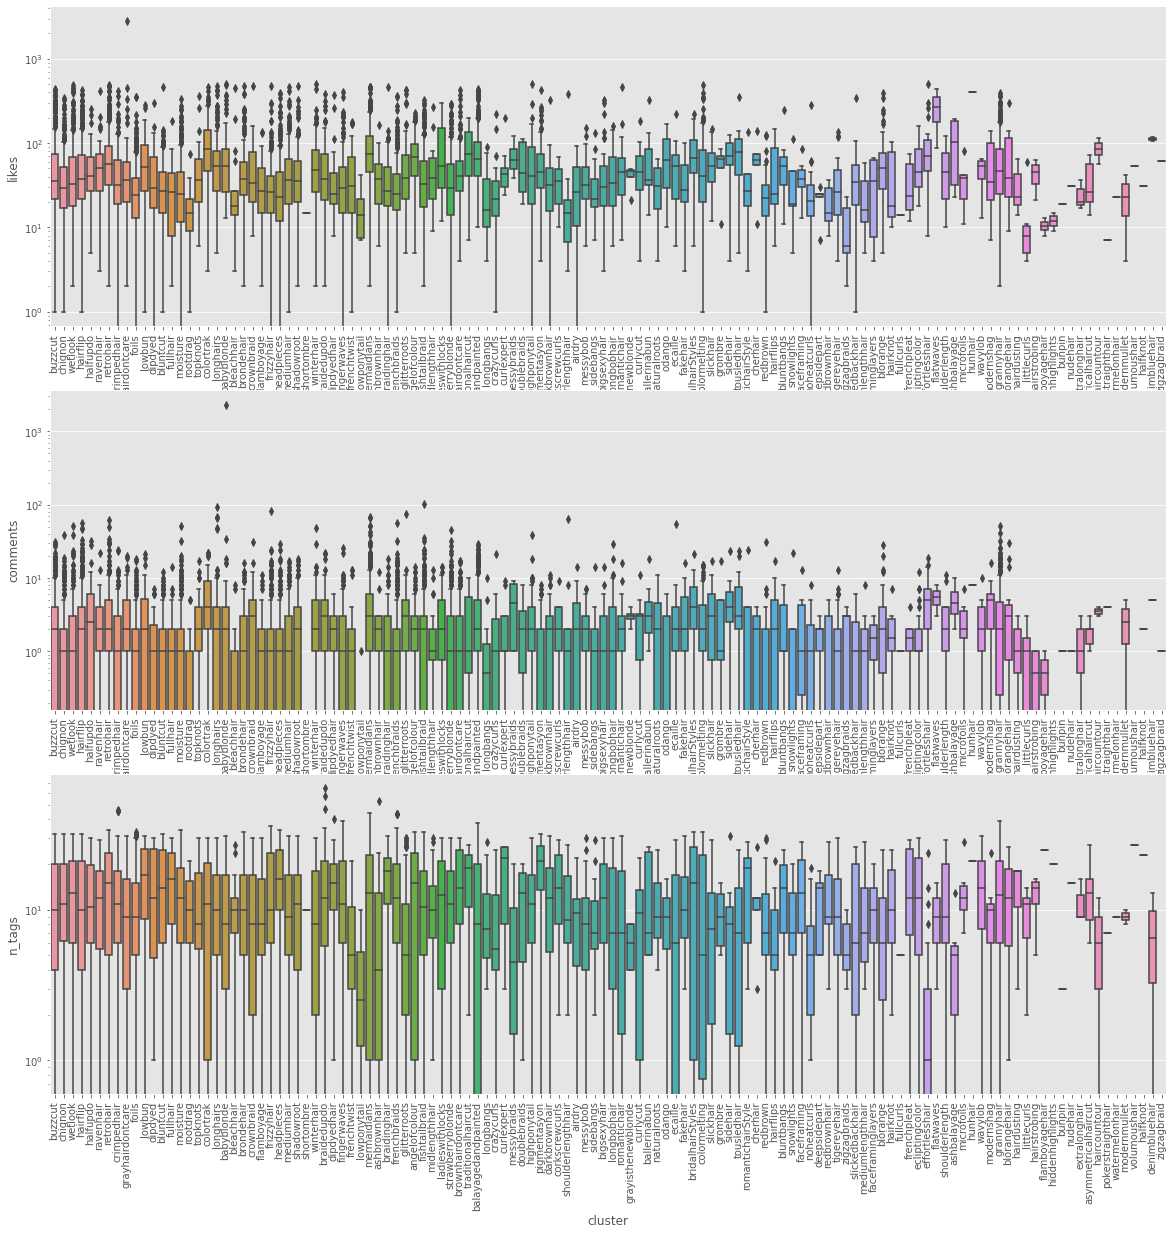

In [9]:
features = ['likes', 'comments', 'n_tags']
fig, axes = plt.subplots(len(features), 1, figsize=(20, 20))
for i, f in enumerate(features):
    g = sns.boxplot(x='cluster', y=f, data=df, ax=axes[i])
    g.set_yscale('log')
    g.set_xticklabels(g.get_xticklabels(), rotation=90);

# Scatter plot to understand linear relationship b/w likes and comments

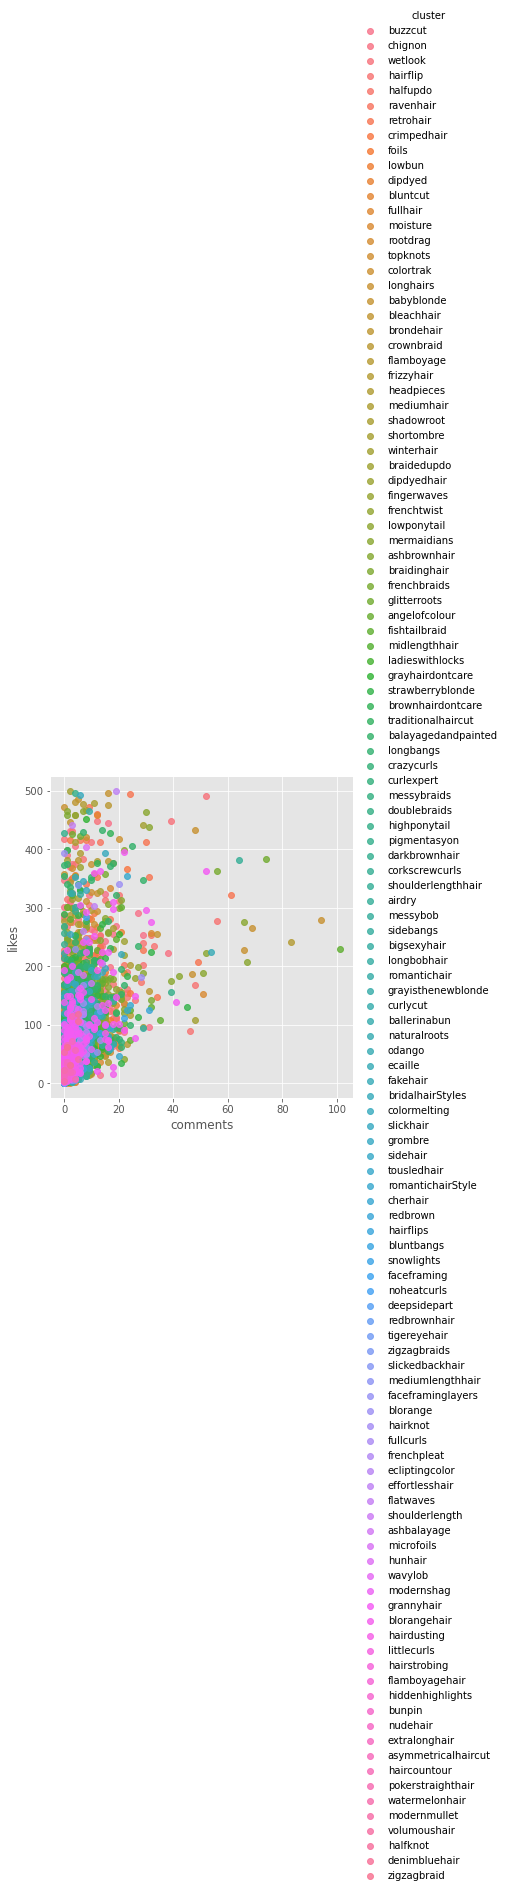

In [10]:
df_tmp = df[(df['comments'] < 2000) & (df['likes'] < 2500)]

g = sns.lmplot(x='comments', y='likes', hue='cluster', fit_reg=False, scatter=True, data=df_tmp)

# Analyzing conditional relationships b/w comments, likes and dayparts type

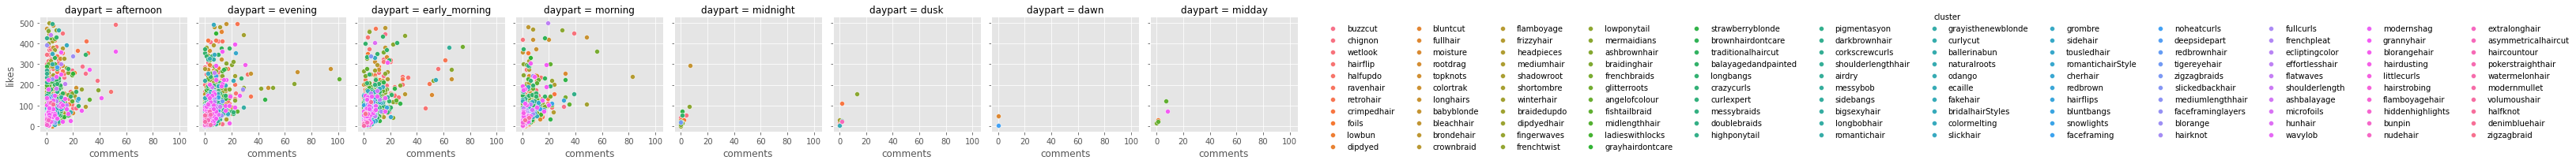

In [11]:
df_tmp = df[(df['comments'] < 2000) & (df['likes'] < 2500)]

g = sns.FacetGrid(df_tmp, col='daypart',  hue='cluster')
g = (g.map(plt.scatter, 'comments', 'likes', edgecolor="w").add_legend(ncol=12))

# Hastags Analysis and Fitting a Light Gradient Boosting Model

In [12]:
df['hastags'] = df['hashtags'].apply(lambda x :  ','.join(x).lower().replace('#', ''))

### Number of Unique Hashtags

In [13]:
nltk.download('stopwords')
eng = stopwords.words('english')

count_vector_params = {
    'ngram_range': (1, 1),
    'stop_words': eng,
    'dtype': np.float32,
    'token_pattern': r'\w{1,}'
}

count_vec = CountVectorizer(**count_vector_params)
count_vec.fit_transform(df['hastags'])

df_words = pd.DataFrame(list(count_vec.vocabulary_.items()), columns=['word', 'count']).sort_values(['count'], ascending=False).reset_index(drop=True)
display(df_words.head())
display(df_words.describe())

[nltk_data] Downloading package stopwords to /Users/stuti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,count
0,zurich,34035
1,zur,34034
2,zuppe,34033
3,zumschlussvolls,34032
4,zumindesteigentlich,34031


,count
count,34036.000000
mean,17017.500000
std,9825.491218
min,0.000000
25%,8508.750000
50%,17017.500000
75%,25526.250000
max,34035.000000


In [20]:
import gc
import threading
import zipfile
from time import sleep

import lightgbm as lightgbm
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder



def run():
    K = 3 # 3-fold validation
    r = 3 # number of repeatations for k-fold 
    N = K * r
    delay = 10  # 10 secs

    threads = []
    preds = pd.DataFrame(columns=list(range(1, N + 1)), index=range(len(df_test_y)))

    nltk.download('stopwords')

    # collecting stopwords for each different language, russian, german and english
    eng = stopwords.words('english')
#         russian = stopwords.words('russian')
#         german = stopwords.words('german')

    count_vector_params = {
        'ngram_range': (1, 2),
        'stop_words': eng,
        'dtype': np.float32,
        'token_pattern': r'\w{1,}'
    }

    tfidf_params = {
        'sublinear_tf': True,
        'norm': 'l2',
        'smooth_idf': False
    }

    svd_params = {
        'n_components': 100,
        'random_state': 42
    }

    lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'auc_mu',
        'max_depth': 32,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'verbose': 0,
        'seed': 42,
        'colsample_bytree': 0.95,
        'subsample': 0.95,
        'num_class' : num_class,
    }

    def _transform_X_k_fold(k, Xs):

        print(f'{k}-fold model transformation of data has started')
        assert len(Xs) == 3

        pipeline = Pipeline([
            ('bow', CountVectorizer(**count_vector_params)),
            ('tfidf', TfidfTransformer(**tfidf_params)),
            ('svd', TruncatedSVD(**svd_params)),
        ])

        pipeline.fit(Xs[0])
        result =  tuple([pipeline.transform(x) for x in Xs])
        print(f'{k}-fold model transformation of data has completed')

        return result

    def _create_model(k, X_train, y_train, X_valid, y_valid):

        print(f'{k}-fold model creation has started')

        train_dataset = lightgbm.Dataset(X_train,
                                         y_train)

        valid_dataset = lightgbm.Dataset(X_valid,
                                         y_valid)

        model = lightgbm.train(lgbm_params,
                               train_dataset,
                               num_boost_round=500,
                               valid_sets=[valid_dataset, train_dataset],
                               valid_names=[f'valid-{k}-{N}', f'train-{k}-{N}'],
                               early_stopping_rounds=50,
                               verbose_eval=5,)

        print(f'{k}-fold model creation has completed')

        return model

    def _run(k, train_index, valid_index):

        X_train, X_valid = df_train_X.iloc[train_index].copy().reset_index(drop=True), \
                           df_train_X.iloc[valid_index].copy().reset_index(drop=True)

        y_train, y_valid = df_train_y.iloc[train_index].copy().reset_index(drop=True), \
                           df_train_y.iloc[valid_index].copy().reset_index(drop=True)

        X_test = df_test_X.copy()

        X_train, X_valid, X_test = _transform_X_k_fold(k, [X_train.values, X_valid.values, X_test.values])

        model = _create_model(k, X_train, y_train, X_valid, y_valid)
        preds[k] = model.predict(X_test)

        free([X_train, X_valid, X_test, y_train, y_valid, model])


    def free(objs):
        for x in objs:
            del x
        gc.collect()

    def _evaluate():
        wait()
        y_test_pred = preds.mean(1)

        auc_scores = {}
        pre_scores = {}
        fpr = {}
        tpr = {}

        pre_micro = {}
        pre_macro = {}

        for c in np.unique(df_test_y):
            y_test_actual = df_test_y.copy()
            y_test_actual = (y_test_actual == c) * 1

            fpr[c], tpr[c], _ = roc_curve(y_test_actual, y_test_pred)
            auc_scores[c] = roc_auc_score(y_test_actual, y_test_pred)
            pre_scores[c] =  fpr[c] / (fpr[c] + tpr[c])


            pre_micro[c] = sum(fpr[c]) / sum(fpr[c] + tpr[c])
            pre_macro[c] = np.mean(pre_scores[c])

        df_res = pd.DataFrame()
        df_res['cluster'] = lblEncoder.inverse_transform(np.unique(df_test_y))
        df_res['auc'] = list(auc_scores.values())
        df_res['pre_micro'] = list(pre_micro.values())
        df_res['pre_macro'] = list(pre_macro.values())

        df_des = df_res.describe()

        df_res.to_csv('result.csv', index=False)
        df_des.to_csv('statistics.csv')


    def wait():
        for k in range(N):
            threads[k].join()

    kf = RepeatedStratifiedKFold(n_splits=K, n_repeats=r, random_state=42)

    k = 1
    for train_index, valid_index in kf.split(df_train_X, df_train_y):
        t = threading.Thread(target=_run, args=(k, train_index, valid_index))

        t.start()
        threads.append(t)

        print(f'{delay} seconds pause')
        sleep(delay)

        print(f'{k}-fold has started!')
        k += 1

    _evaluate()

In [21]:
# calculating count of cluster per cluster by aggregation
df_agg = df[['cluster']].groupby(['cluster']).aggregate({'cluster' : ['count']}).sort_values([('cluster', 'count')])

# filtering most frequently occuring cluster types from data
f_list = df_agg[df_agg[('cluster', 'count')] > 100].index.tolist()
df = df[df['cluster'].apply(lambda x: x in f_list)]

# re-arranging cluster-id's using LabelEncoder
lblEncoder = LabelEncoder()
lblEncoder.fit(df['cluster'])
df['cluster'] = lblEncoder.transform(df['cluster'])

# preparing data for the model
df_X = df['hastags']
df_y = df['cluster']

# num_of_classes in multi-class classification
num_class = len(np.unique(df_y))

# train-test split (0.7-0.3)
df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

run()

[nltk_data] Downloading package stopwords to /Users/stuti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


10 seconds pause
1-fold model transformation of data has started
1-fold model transformation of data has completed
1-fold model creation has started
Training until validation scores don't improve for 50 rounds
[5]	train-1-9's auc_mu: 0.996041	valid-1-9's auc_mu: 0.988494
[10]	train-1-9's auc_mu: 0.99631	valid-1-9's auc_mu: 0.989509
[15]	train-1-9's auc_mu: 0.996397	valid-1-9's auc_mu: 0.989583
1-fold has started!
10 seconds pause
2-fold model transformation of data has started
[20]	train-1-9's auc_mu: 0.996465	valid-1-9's auc_mu: 0.989464
2-fold model transformation of data has completed
2-fold model creation has started
Training until validation scores don't improve for 50 rounds
[25]	train-1-9's auc_mu: 0.996511	valid-1-9's auc_mu: 0.989539
[5]	train-2-9's auc_mu: 0.995999	valid-2-9's auc_mu: 0.987916
2-fold has started!
10 seconds pause
3-fold model transformation of data has started
3-fold model transformation of data has completed
3-fold model creation has started
[30]	train-1-9's

/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide
/Users/stuti/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid valu

In [23]:
pd.read_csv('result.csv')

,cluster,auc,pre_micro,pre_macro
0,0,0.969148,0.345655,NaN
1,1,0.842142,0.318144,NaN
2,2,0.468942,0.512514,NaN
3,3,0.691819,0.413320,NaN
4,4,0.466037,0.516138,NaN
5,5,0.469080,0.514135,NaN
6,6,0.385502,0.559746,NaN
7,7,0.310772,0.593667,NaN
8,8,0.657663,0.421978,NaN
9,9,0.338613,0.586400,NaN


In [24]:
pd.read_csv('statistics.csv')

,Unnamed: 0,cluster,auc,pre_micro,pre_macro
0,count,28.000000,28.000000,28.000000,0.0
1,mean,13.500000,0.511905,0.497622,NaN
2,std,8.225975,0.166218,0.075744,NaN
3,min,0.000000,0.310772,0.318144,NaN
4,25%,6.750000,0.392202,0.454237,NaN
5,50%,13.500000,0.455559,0.520662,NaN
6,75%,20.250000,0.593058,0.555381,NaN
7,max,27.000000,0.969148,0.593667,NaN
